In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

In [20]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')

# Then, join the result with df_merchants on merchant_id
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')


In [21]:
df = df_merged

In [22]:
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country_x', 'country_y', 'sex', 'education', 'primary_source_of_income'
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

numerical_cols = [
    'amount', 'session_length_seconds', 'age', 'risk_score', 'trust_score',
    'number_of_alerts_last_6_months', 'avg_transaction_amount',
    'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
]

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# Temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['days_since_signup'] = (df['timestamp'] - df['signup_date']).dt.total_seconds() / (3600 * 24)

numerical_cols += ['hour', 'day_of_week', 'days_since_signup']

# Location
df['lat'] = df['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else np.nan)
df['long'] = df['location'].apply(lambda x: x['long'] if isinstance(x, dict) else np.nan)

numerical_cols += ['lat', 'long']

In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

for col in binary_cols:
    df[col] = df[col].astype(int)

In [25]:
user_column = 'user_id'
target_column = 'is_fraud'
time_window_hours = 24  # 2-hour window
padding_value = 0  

# Convert timestamp to datetime if not already
df['timestamp'] = pd.to_datetime(df['timestamp'])

data_sequences = []
labels = []

# Group by user
grouped = df.groupby(user_column)

for user_id, user_data in grouped:
    # Sort by timestamp
    user_data = user_data.sort_values(by='timestamp')
    
    # Convert to numpy arrays
    user_data_values = user_data[numerical_cols].values
    timestamps = user_data['timestamp'].values
    target_values = user_data[target_column].values
    
    # For each transaction, find all transactions within the 2-hour window before it
    for i in range(1, len(user_data)):  # Start from 1 since first transaction has no history
        current_time = timestamps[i]
        window_start = current_time - pd.Timedelta(hours=time_window_hours)
        
        # Get indices of transactions within the time window
        mask = (timestamps >= window_start) & (timestamps < current_time)
        window_indices = np.where(mask)[0]
        
        if len(window_indices) > 0:
            # Get the sequence data
            sequence_data = user_data_values[window_indices]
            
            # If sequence is shorter than desired, you can pad it (optional)
            # Here we're using all available data in the window without padding
            data_sequences.append(sequence_data)
            labels.append(target_values[i])
        else:
            # If no transactions in window, you might want to skip or handle differently
            # Here we'll create a zero sequence with shape (1, num_features)
            empty_sequence = np.full((1, len(numerical_cols)), padding_value)
            data_sequences.append(empty_sequence)
            labels.append(target_values[i])

# Now we have sequences of varying lengths - need to pad them to same length for RNN
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find maximum sequence length in the data
max_seq_length = max(len(seq) for seq in data_sequences)

# Pad all sequences to max length
data_sequences_padded = pad_sequences(
    data_sequences, 
    maxlen=max_seq_length, 
    dtype='float32', 
    padding='post', 
    value=padding_value
)

labels = np.array(labels)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_sequences_padded, 
    labels, 
    test_size=0.2, 
    random_state=42
)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define RNN Model
model = Sequential()
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(max_seq_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


C:\Users\antek\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [29]:
from sklearn.utils.class_weight import compute_class_weight


y_train_class = y_train  

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(zip(np.unique(y_train_class), class_weights))

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=64, class_weight=class_weight_dict, validation_data=(X_test, y_test))

Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5094 - auc: 0.5020 - loss: 0.6944 - val_accuracy: 0.0996 - val_auc: 0.5000 - val_loss: 0.7002
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4843 - auc: 0.4987 - loss: 0.6926 - val_accuracy: 0.9004 - val_auc: 0.4980 - val_loss: 0.6893
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5478 - auc: 0.4971 - loss: 0.6918 - val_accuracy: 0.0993 - val_auc: 0.5018 - val_loss: 0.6950
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4701 - auc: 0.4997 - loss: 0.6941 - val_accuracy: 0.1000 - val_auc: 0.4990 - val_loss: 0.6935
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5216 - auc: 0.5005 - loss: 0.6927 - val_accuracy: 0.9008 - val_auc: 0.4996 - val_loss: 0.6895
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5247 - auc: 0.5006 - loss: 0.6928 - val_accuracy: 0.0998 - val_auc: 0.5008 - val_loss: 0.6955
Epoch 7/10
6000/6000 ━

KeyboardInterrupt: 

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step


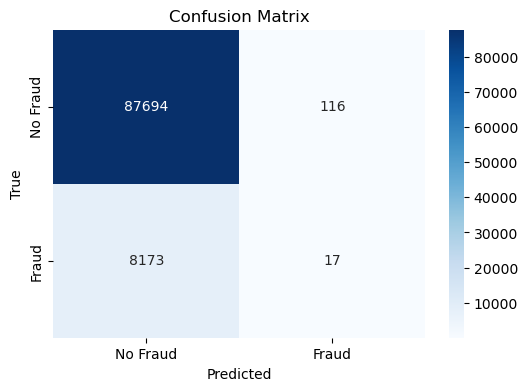

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     87810
           1       0.13      0.00      0.00      8190

    accuracy                           0.91     96000
   macro avg       0.52      0.50      0.48     96000
weighted avg       0.85      0.91      0.87     96000

AUC: 0.5004300327088165


In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)  
y_pred_class = (y_pred > 0.5).astype(int)  


cm = confusion_matrix(y_test, y_pred_class)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n", classification_report(y_test, y_pred_class))


auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')